# smFRET Analysis

This notebook is for simple analysis of smFRET data, starting with an hdf5 file, background correction, burst search, burst selection, and ending with a FRET efficiency histogram that can be fitted with a gaussian(s). Burst data can be exported as a .csv for analysis elsewhere.

You can analysise uncorrected data if you are simply looking for relative changes in the conformational ensemble, or accurate FRET correction parameters can be supplied if you want FRET efficiencies that can be converted to distances.

If you are doing Accurate FRET correction, it is advised to run this notebook first with no corrections just to check your data.

# Import packages

Importing these packages may take a minute or so

In [2]:
from fretbursts import *
sns = init_notebook()
import lmfit
import phconvert
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from fretbursts.burstlib_ext import burst_search_and_gate
import tables

# Name and Load in data

First name the data file and check it exists, it will look for the file starting from wherever this notebook is saved.

In [3]:
filename = "exampledata/1a1.hdf5"
if os.path.isfile(filename):
    print("File found")
else:
    print("File not found, check file name is correct")

File found


Load in the file and set correction factors. If you aren't using accurate correction factors, set d.leakage and d.dir_ex to 0 and d.gamma and d.beta to 1

You may get warnings that some parameters are not defined in the file, this is fine as they will be defined in this workbook anyway

This cell also contains code to sort the timestamps as they are loaded. This is because the timestamps are not always saved in chronological order, and this can confuse some of FRETBursts functions.

In [4]:
d = loader.photon_hdf5(filename)
for i in range(0, len(d.ph_times_t)): #sorting code
    indices = d.ph_times_t[i].argsort()
    d.ph_times_t[i], d.det_t[i] = d.ph_times_t[i][indices], d.det_t[i][indices]
#d.leakage = 0.082 #alpha
#d.dir_ex = 0.07 #delta
#d.gamma = 0.854
#d.beta = 0.847
d.leakage = 0.
d.dir_ex = 0.
d.gamma = 1.
d.beta = 1.

# Check alternation cycle is correct

We need to check that the ALEX parameters defined in the HDF5 file metadata are appropriate for the laser cycle used in the experiment. If this is correct, the following histogram should fit within the shaded boxes. It is a combined plot of every photon that arrives over the supplied alternation periods. 

Also check for abnormal spikes or waves in the histogram as this can indicate laser issues.

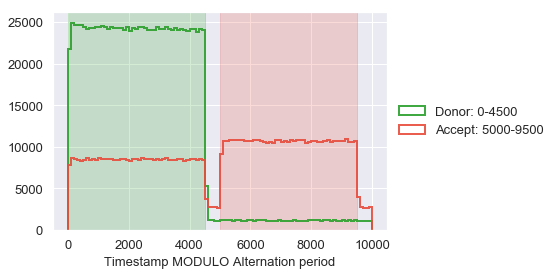

In [5]:
bpl.plot_alternation_hist(d)

IF THE ABOVE HISTOGRAM LOOKS CORRECT: then run loader.alex_apply_period below, which rewrites the time stamps into groups based on their excitation period. If you want to change the alternation period after this you will have to reload the data into FRET bursts.

IF THE ABOVE HISTOGRAM LOOKS WRONG: then the supplied alternation parameters do not match up to the alternation of the lasers in the data. This could be because the lasers were actually on a different alternation, or because the data set doesn't start at zero so is frame shifted etc.

In this case, you can un-hash the code below and alter the parameters manually.

In [6]:
#d.add(det_donor_accept = (0, 1),
#    alex_period = 10000,
#    offset = 0,
#    D_ON = (0, 4500),
#    A_ON = (5000, 9500))

This next function will then sort each photon into channels depending on which laser was on, according to the information used to plot the alternation period histogram above.

In [7]:
loader.alex_apply_period(d)
time = d.time_max
print('Total data time = %s'%time)

# Total photons (after ALEX selection):     2,003,013
#  D  photons in D+A excitation periods:    1,141,024
#  A  photons in D+A excitation periods:      861,989
# D+A photons in  D  excitation period:     1,471,746
# D+A photons in  A  excitation period:       531,267

Total data time = 1799.91348457


The following will plot a time trace of the first five seconds of your experiment. You would have checked before and during the experiment, but here you can check the number of bursts per second. You can change t1 and t2 to plot different parts of the experiment.

C:\Users\chp17ba\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
C:\Users\chp17ba\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


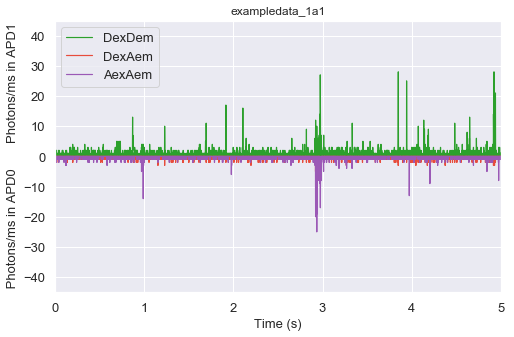

In [8]:
t1, t2 = 0, 5
dplot(d, timetrace, binwidth=1e-3, tmin=t1, tmax=t2, figsize=(8,5))
plt.xlim(t1,t2);
plt.ylim(-45,45);
plt.ylabel(" Photons/ms in APD0       Photons/ms in APD1");
plt.legend()

# Background Estimation

Background estimation works by plotting log of photons by the delay between them, assuming a poisson distribution of photon arrivals and fitting a line. The plot will contain single molecule bursts however, so a threshold (in microseconds) has to be defined where the fit begins. Choosing the right threshold is a trade off between correctly ignoring the burst photons (accuracy) and getting enough photons to calculate the background (precision). 

"time_s=" will change how regularly the background is recalculated

 - Calculating BG rates ... [DONE]


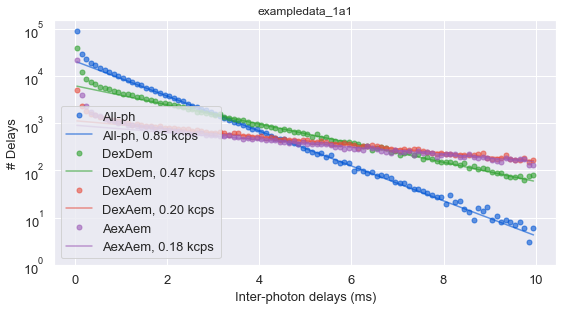

In [9]:
threshold = 1500
d.calc_bg(bg.exp_fit, time_s=300, tail_min_us=(threshold),)
dplot(d, hist_bg, show_fit=True)

This code will plot the calculated background in each window and acts as a good reporter of whether anything important has happened to the solution over the time course of the experiment. Adsorption to the coverslip can cause a decrease in signal, whereas evaporation (and hence concentration) can cause an increase.

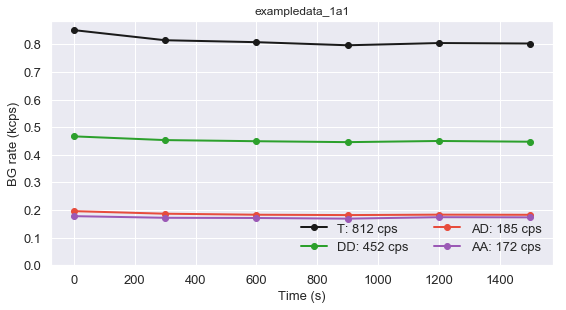

In [10]:
dplot(d, timetrace_bg);

# Burst Searching and Selecting

"d.burst_search()" can be used to do an all photon burst search (APBS), however "burst_search_and_gate(d)" will apply a DCBS / dual channel burst search (Nir 2006), this effectively does independent searches in the DD+DA channel and the AA channel, and then returns the intersection of these bursts, ensuring that any FRET information is only included whilst an acceptor is still active in the detection volume.

The two numbers given to "F=" are the signal to background threshold in the DD+DA and AA channels respectively. If your background is particularly high in one but not the other you may want to change these independently. Additionally if your sample shows signs of photobleaching, increasing the F value can increase the discriminatory power of the dual channel burst search to remove the single dye sections of the burst, at the cost of smaller and fewer bursts.

In [11]:
bsearch=burst_search_and_gate(d, F=(20, 20), m=10, mute=True)

The following will plot a graph of burst number vs size (under green excitation) which can inform your selection thresholding. 

(0, 200)

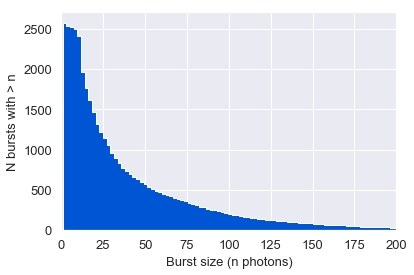

In [12]:
sizes = bsearch.burst_sizes_ich(add_naa=False)
plt.hist(sizes, cumulative=-1, bins = 200, histtype="stepfilled", density=False)
plt.xlabel('Burst size (n photons)')
plt.ylabel("N bursts with > n")
plt.xlim(0,200)

We can now set thresholds on how many photons we want in each burst, this can be done on all channels together, or just one channel. Thresholding DD+DA will reduce the width in E, thresholding in AA will ensure there are no donor only bursts.

In [13]:
allbursts = bsearch.select_bursts(select_bursts.size, add_naa=True, th1=20,) #all channels
dlbursts = allbursts.select_bursts(select_bursts.size, th1=50) #DD + DA
dlbursts = dlbursts.select_bursts(select_bursts.naa , th1=50) #AA

For good measure, we'll do an all photons burst seach and all photons selection so we can see a spread of all three populations

In [14]:
d.burst_search(L=10, m=10, F=20)
allphotons = d.select_bursts(select_bursts.size, add_naa=True, th1=50,) #all channels

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


# Histograms

Now we can start plotting and fitting the data. We'll plot all 3 populations first, then the result of the dual channel burst search and selection.

C:\Users\chp17ba\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


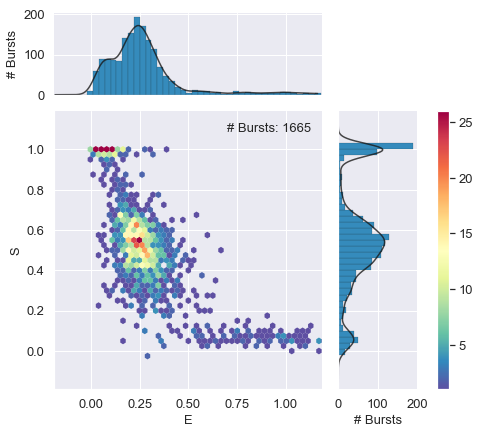

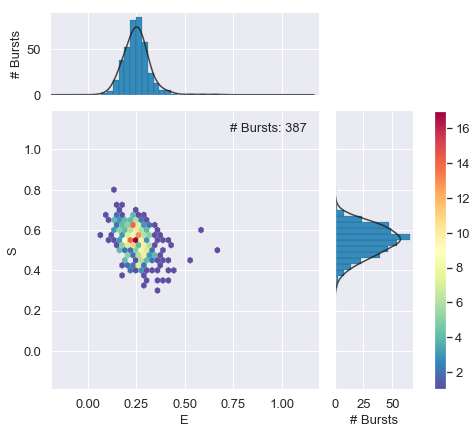

In [15]:
g=alex_jointplot(allphotons) #plots all photons burst search with allchannels selection
g=alex_jointplot(dlbursts) #plots the dual channel burst search with doubly labelled selection

Next we will plot the 1D FRET efficiency histogram and plot a gaussian to it. We can also plot two or three gaussians but you will need to change the model to do this. 

If you set pdf=True then the data will be displayed as a probability density function, pdf=False will give it as number of bursts instead

amplitude    center      sigma
0   11.2117  0.248311  0.0531923

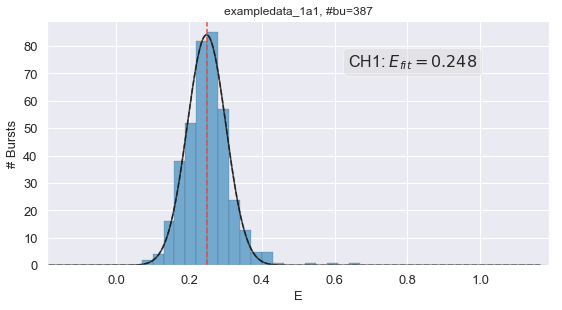

In [16]:
model = mfit.factory_gaussian()
dlbursts.E_fitter.fit_histogram(model=model, verbose=False, pdf=False)
dplot(dlbursts, hist_fret, pdf=False, show_model=True, show_fit_value=True, fit_from='center');
dlbursts.E_fitter.params

This will export the data to a .csv file, type the save location between the ""'s. This csv file can be opened in excel or origin and contains information about each burst, most importantly E and S but also things like burst length and width.

In [17]:
csvfile = filename+".csv"
burstmatrix = bext.burst_data(dlbursts)
burstmatrix.to_csv(csvfile)

This will give you all of the plots again. Unhash the plt.savefig lines to save the figures as .svg's which can then be used in any vector graphics program.

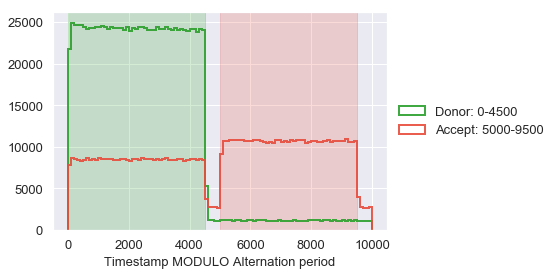

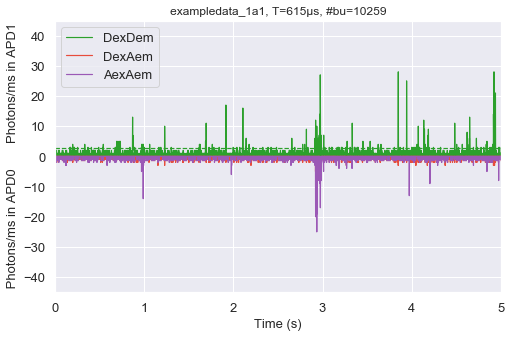

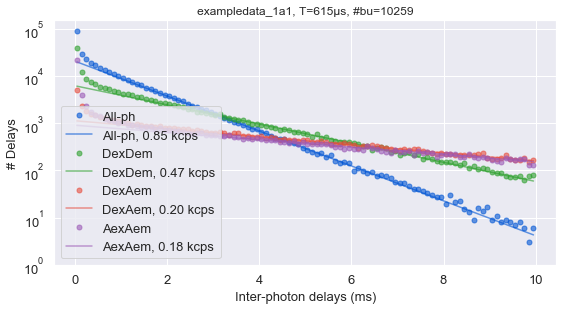

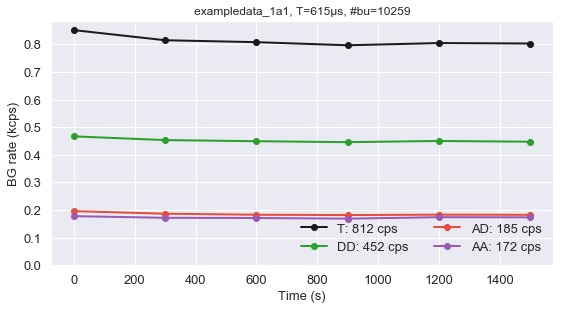

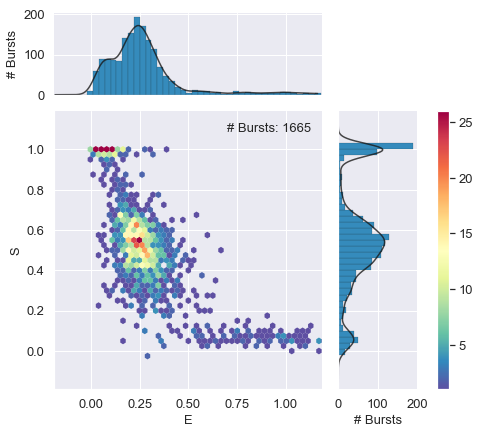

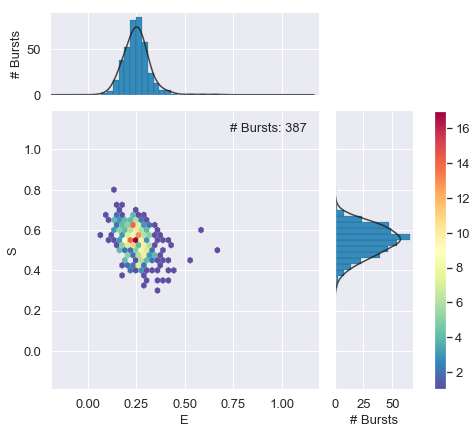

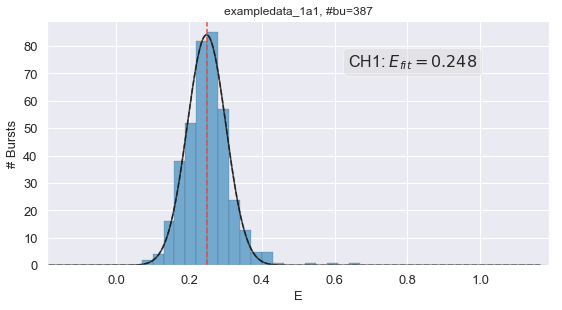

In [18]:
c = loader.photon_hdf5(filename) #loaded as c this time so as not to overwrite 
for i in range(0, len(c.ph_times_t)): #sorting code
    indices = c.ph_times_t[i].argsort()
    c.ph_times_t[i], c.det_t[i] = c.ph_times_t[i][indices], c.det_t[i][indices]
bpl.plot_alternation_hist(c) #alternation hist
#plt.savefig((filename+"altplot.svg"), format="svg")
dplot(d, timetrace, binwidth=1e-3, tmin=t1, tmax=t2, figsize=(8,5)) #timetrace
#plt.savefig((filename+"timetrace.svg"), format="svg")
plt.xlim(0,5);
plt.ylim(-45,45);
plt.ylabel(" Photons/ms in APD0       Photons/ms in APD1");
plt.legend()
dplot(d, hist_bg, show_fit=True) #background plot
#plt.savefig((filename+"bgplot.svg"), format="svg")
dplot(d, timetrace_bg); #backgroundtimetrace
#plt.savefig((filename+"bgtrace.svg"), format="svg")
g=alex_jointplot(allphotons) #plots all photons burst search with allchannels selection
#plt.savefig((filename+"ESall.svg"), format="svg")
g=alex_jointplot(dlbursts) #plots the dual channel burst search with doubly labelled selection
#plt.savefig((filename+"ESdl.svg"), format="svg")
dplot(dlbursts, hist_fret, pdf=False, show_model=True, show_fit_value=True, fit_from='center'); #1D FRET histogram
#plt.savefig((filename+"1DEHist.svg"), format="svg")

This will give you all the metadata in your file. This code may fail if you did not enter information into some of the fields. If that happens, just hash out the corresponding line.

In [19]:
h5file = tables.open_file(filename)
#print("Sample name       =", (str(h5file.root.sample.sample_name.read()))[1:])
print("Aquisition length =", h5file.root.acquisition_duration.read())
print("Buffer            =", (str(h5file.root.sample.buffer_name.read()))[1:])
print("Description       =", (str(h5file.root.description.read()))[1:])
print("Dye names         =", (str(h5file.root.sample.dye_names.read()))[1:])
print("User              =", (str(h5file.root.identity.author.read()))[1:])
print("Alex Periods      =", h5file.root.photon_data.measurement_specs.alex_excitation_period1.read(), h5file.root.photon_data.measurement_specs.alex_excitation_period2.read())
print("Laser powers (g,r)=", h5file.root.setup.excitation_input_powers.read())
print("Filename          =", filename)

Aquisition length = 1799.9
Buffer            = '5mM NaCl, 20mM MgCl2, 50 mM Tris 8.0'
Description       = 'Enter additional notes here'
Dye names         = 'Atto550,Atto647N'
User              = 'Default user'
Alex Periods      = [0, 4500] [5000, 9500]
Laser powers (g,r)= [52. 15.]
Filename          = exampledata/1a1.hdf5
